### 3.1 Обучение модели
Разработайте агента моделирования, который на основе размеченного набора данных обучает модель машинного обучения для классификации транзакций по уровню риска (низкий, средний, высокий) и сложности верификации. Агент использует несколько алгоритмов и сравнивает их по метрикам: точность, полнота, F1-мера, ROC-AUC. Выбирает лучшую модель, тестирует её на отложенной выборке и сохраняет в указанной директории. 

In [1]:
# =========================
# 3.3 — ЯЧЕЙКА 1
# Загрузка данных + подготовка времени
# Результат:
# - df: транзакции с колонками dt, day, month, abs_amount, is_high_risk
# =========================

import sqlite3
import pandas as pd
import numpy as np

# ===== НАСТРОЙКИ (менять на соревнованиях) =====
DB_PATH = "../db/app.db"
TABLE = "transactions_labeled"

DATE_COL = "tr_datetime"      # исходная дата/время
AMOUNT_COL = "amount"         # сумма (может быть +/-)
MCC_COL = "mcc_code"
FLOW_COL = "flow"             # spend/income
RISK_COL = "risk_level"       # low/medium/high

# Если datetime "0 10:23:26" (день_индекс + время), задаём базовую дату:
BASE_DATE = "2020-01-01"      # можно менять

# ===== ЗАГРУЗКА (берём только нужные колонки) =====
cols = [DATE_COL, AMOUNT_COL, MCC_COL, FLOW_COL, RISK_COL]
sql = f"SELECT {', '.join(cols)} FROM {TABLE}"

con = sqlite3.connect(DB_PATH)
df = pd.read_sql(sql, con)
con.close()

print("✅ Loaded:", df.shape)
print("📌 Columns:", list(df.columns))
display(df.head(3))

# ===== Приведение даты =====
# Вариант A: если DATE_COL уже полноценный timestamp
# Вариант B: если формат "day_index HH:MM:SS" (как у тебя)
s = df[DATE_COL].astype(str)

if s.str.match(r"^\d+\s+\d{2}:\d{2}:\d{2}$").all():
    day_idx = s.str.split().str[0].astype(int)
    time_part = s.str.split().str[1]
    base = pd.Timestamp(BASE_DATE)
    df["dt"] = base + pd.to_timedelta(day_idx, unit="D") + pd.to_timedelta(time_part)
    parse_mode = "day_index + time"
else:
    df["dt"] = pd.to_datetime(df[DATE_COL], errors="coerce")
    parse_mode = "pd.to_datetime"

if df["dt"].isna().mean() > 0.01:
    print("⚠️ Warning: много NaT в dt -> проверь формат даты в DATE_COL")

df["day"] = df["dt"].dt.floor("D")
df["month"] = df["dt"].dt.to_period("M").dt.to_timestamp()

# ===== Полезные признаки =====
df["abs_amount"] = df[AMOUNT_COL].abs()
df["is_high_risk"] = (df[RISK_COL].astype(str).str.lower() == "high").astype(int)

print(f"✅ Date parsing mode: {parse_mode}")
print("✅ History span:", df["day"].min(), "->", df["day"].max())
print("✅ Unique months:", df["month"].nunique())
print("✅ High-risk share overall:", round(df["is_high_risk"].mean(), 4))

✅ Loaded: (2000000, 5)
📌 Columns: ['tr_datetime', 'amount', 'mcc_code', 'flow', 'risk_level']


,tr_datetime,amount,mcc_code,flow,risk_level
0,0 10:23:26,-2245.92,4814,spend,low
1,1 10:19:29,56147.89,6011,income,medium
2,1 10:20:56,-56147.89,4829,spend,medium


✅ Date parsing mode: day_index + time
✅ History span: 2020-01-01 00:00:00 -> 2021-04-01 00:00:00
✅ Unique months: 16
✅ High-risk share overall: 0.0462


In [2]:
# =========================
# 3.3 — ЯЧЕЙКА 2
# Агрегации по МЕСЯЦАМ:
# 1) общий объём и активность (total_volume, tx_count)
# 2) доля high-risk по категориям MCC (monthly_mcc)
# 3) структура income/spend (monthly_flow)
#
# Результат:
# - monthly_total
# - monthly_mcc
# - monthly_flow
# =========================

# 1) Общие метрики по месяцам
monthly_total = (
    df.groupby("month")
      .agg(
          total_volume=("abs_amount", "sum"),
          tx_count=(AMOUNT_COL, "size"),
          high_risk_share=("is_high_risk", "mean")
      )
      .reset_index()
      .sort_values("month")
)

print("✅ monthly_total:", monthly_total.shape, "| months:", monthly_total["month"].nunique())
display(monthly_total.head(10))

# 2) Доля high-risk по MCC
monthly_mcc = (
    df.groupby(["month", MCC_COL])
      .agg(
          mcc_volume=("abs_amount", "sum"),
          mcc_tx=(AMOUNT_COL, "size"),
          high_risk_share=("is_high_risk", "mean"),
      )
      .reset_index()
      .sort_values(["month", MCC_COL])
)

print("✅ monthly_mcc:", monthly_mcc.shape, "| unique mcc:", monthly_mcc[MCC_COL].nunique())
display(monthly_mcc.head(10))

# 3) Потоки income/spend
monthly_flow = (
    df.groupby(["month", FLOW_COL])
      .agg(
          volume=("abs_amount", "sum"),
          tx=(AMOUNT_COL, "size")
      )
      .reset_index()
      .sort_values(["month", FLOW_COL])
)

print("✅ monthly_flow:", monthly_flow.shape, "| flows:", list(monthly_flow[FLOW_COL].unique()))
display(monthly_flow.head(10))

# Мини-проверка: суммы по flow должны примерно сходиться с total (по объёму)
check = (
    monthly_flow.groupby("month")["volume"].sum().reset_index()
    .merge(monthly_total[["month", "total_volume"]], on="month", how="left")
)
check["diff"] = (check["volume"] - check["total_volume"]).abs()
print("✅ Sanity check (sum(flow) vs total): max_abs_diff =", float(check["diff"].max()))
display(check.head(10))

✅ monthly_total: (16, 4) | months: 16


,month,total_volume,tx_count,high_risk_share
0,2020-01-01,8.895717e+09,110397,0.047818
1,2020-02-01,9.366198e+09,109153,0.050809
2,2020-03-01,9.909585e+09,123738,0.047730
3,2020-04-01,1.000783e+10,123066,0.047275
4,2020-05-01,1.348047e+10,132636,0.055618
5,2020-06-01,7.326408e+09,110275,0.039420
6,2020-07-01,9.847096e+09,137286,0.042036
7,2020-08-01,9.670173e+09,142645,0.041684
8,2020-09-01,9.938851e+09,141374,0.042136
9,2020-10-01,9.851468e+09,143791,0.042179


✅ monthly_mcc: (2692, 5) | unique mcc: 184


,month,mcc_code,mcc_volume,mcc_tx,high_risk_share
0,2020-01-01,742,43525.85,4,0.000000
1,2020-01-01,1711,40987.96,1,0.000000
2,2020-01-01,1799,73475.14,4,0.000000
3,2020-01-01,3000,39296778.61,77,0.259740
4,2020-01-01,3351,308744.02,2,0.500000
5,2020-01-01,3501,1558283.50,9,0.555556
6,2020-01-01,4111,465606.17,19,0.000000
7,2020-01-01,4112,16196005.85,293,0.068259
8,2020-01-01,4121,290102.46,18,0.000000
9,2020-01-01,4131,117514.17,5,0.000000


✅ monthly_flow: (32, 4) | flows: ['income', 'spend']


,month,flow,volume,tx
0,2020-01-01,income,2.927781e+09,16732
1,2020-01-01,spend,5.967937e+09,93665
2,2020-02-01,income,3.266128e+09,19118
3,2020-02-01,spend,6.100070e+09,90035
4,2020-03-01,income,3.457286e+09,25780
5,2020-03-01,spend,6.452299e+09,97958
6,2020-04-01,income,3.394452e+09,26210
7,2020-04-01,spend,6.613373e+09,96856
8,2020-05-01,income,4.555973e+09,23741
9,2020-05-01,spend,8.924495e+09,108895


✅ Sanity check (sum(flow) vs total): max_abs_diff = 1.9073486328125e-06


,month,volume,total_volume,diff
0,2020-01-01,8.895717e+09,8.895717e+09,1.907349e-06
1,2020-02-01,9.366198e+09,9.366198e+09,0.000000e+00
2,2020-03-01,9.909585e+09,9.909585e+09,0.000000e+00
3,2020-04-01,1.000783e+10,1.000783e+10,0.000000e+00
4,2020-05-01,1.348047e+10,1.348047e+10,0.000000e+00
5,2020-06-01,7.326408e+09,7.326408e+09,9.536743e-07
6,2020-07-01,9.847096e+09,9.847096e+09,0.000000e+00
7,2020-08-01,9.670173e+09,9.670173e+09,0.000000e+00
8,2020-09-01,9.938851e+09,9.938851e+09,0.000000e+00
9,2020-10-01,9.851468e+09,9.851468e+09,0.000000e+00


In [3]:
# =========================
# 3.3 — ЯЧЕЙКА 3
# ML-прогноз на 12 месяцев вперёд (сезонность + лаги)
# Прогнозируем:
# - total_volume
# - high_risk_share
# - income/spend volumes
#
# Результат:
# - fc_total
# - fc_high
# - fc_flow (income/spend)
# =========================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

HORIZON_MONTHS = 12
RANDOM_STATE = 42

def make_time_features(month_series: pd.Series) -> pd.DataFrame:
    """month_series: datetime series (month start)"""
    m = month_series.dt.month.astype(int)
    out = pd.DataFrame(index=month_series.index)
    out["month_idx"] = np.arange(len(month_series))
    out["sin_m"] = np.sin(2*np.pi*m/12)
    out["cos_m"] = np.cos(2*np.pi*m/12)
    return out

def build_supervised(series_df: pd.DataFrame, y_col: str, lags=(1,2,3)):
    """
    series_df columns: month, y_col
    returns dataframe with features + target
    """
    s = series_df.sort_values("month").reset_index(drop=True).copy()

    # time feats
    tf = make_time_features(s["month"])
    s = pd.concat([s, tf], axis=1)

    # lags
    for L in lags:
        s[f"lag_{L}"] = s[y_col].shift(L)

    # rolling mean (по прошлым)
    s["roll_mean_3"] = s[y_col].shift(1).rolling(3).mean()

    return s

def forecast_12m(series_df: pd.DataFrame, y_col: str, horizon=12):
    """
    series_df columns: month, y_col
    returns: forecast_df with future months + y_forecast, plus fitted model
    """
    base = build_supervised(series_df, y_col=y_col, lags=(1,2,3))

    # train data (drop NaN from lags)
    train_df = base.dropna().reset_index(drop=True)
    if len(train_df) < 5:
        raise ValueError(f"Too few samples for training after lags: {y_col} -> {len(train_df)}")

    X = train_df.drop(columns=["month", y_col])
    y = train_df[y_col].values

    # validation: last 3 points (если хватает)
    if len(train_df) >= 10:
        split = len(train_df) - 3
        X_tr, X_te = X.iloc[:split], X.iloc[split:]
        y_tr, y_te = y[:split], y[split:]
    else:
        X_tr, X_te, y_tr, y_te = X, X, y, y

    model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    model.fit(X_tr, y_tr)

    if len(train_df) >= 10:
        pred_te = model.predict(X_te)
        mae = mean_absolute_error(y_te, pred_te)
        print(f"✅ {y_col}: val_MAE(last3m)={mae:.4f}")
    else:
        print(f"✅ {y_col}: not enough history for holdout (trained on all)")

    # --- recursive future forecast ---
    last_month = pd.to_datetime(series_df["month"].max())
    future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")

    # keep past+preds for lags
    tmp = series_df.sort_values("month")[["month", y_col]].reset_index(drop=True).copy()

    preds = []
    for fm in future_months:
        # build one-row features
        m_series = pd.Series([pd.to_datetime(fm)])
        tf = make_time_features(m_series)

        row = {
            "month_idx": len(tmp),
            "sin_m": float(tf["sin_m"].iloc[0]),
            "cos_m": float(tf["cos_m"].iloc[0]),
        }

        # lags
        for L in (1,2,3):
            row[f"lag_{L}"] = float(tmp[y_col].iloc[-L]) if len(tmp) >= L else np.nan

        # rolling mean
        row["roll_mean_3"] = float(tmp[y_col].iloc[-3:].mean()) if len(tmp) >= 3 else np.nan

        X_new = pd.DataFrame([row]).fillna(0.0)
        y_hat = float(model.predict(X_new)[0])

        preds.append(y_hat)
        tmp = pd.concat([tmp, pd.DataFrame({"month":[fm], y_col:[y_hat]})], ignore_index=True)

    forecast_df = pd.DataFrame({"month": future_months, f"{y_col}_forecast": preds})
    return forecast_df, model


# ============================================================
# 1) total_volume прогноз
# ============================================================
series_total = monthly_total[["month", "total_volume"]].copy()
fc_total, model_total = forecast_12m(series_total, y_col="total_volume", horizon=HORIZON_MONTHS)
print("✅ fc_total:", fc_total.shape)
display(fc_total.head())

# ============================================================
# 2) high_risk_share прогноз
# ============================================================
series_high = monthly_total[["month", "high_risk_share"]].copy()
fc_high, model_high = forecast_12m(series_high, y_col="high_risk_share", horizon=HORIZON_MONTHS)
print("✅ fc_high:", fc_high.shape)
display(fc_high.head())

# ============================================================
# 3) income/spend прогноз (по отдельности)
# ============================================================
# pivot -> 2 ряда: income_volume, spend_volume
flow_pivot = (
    monthly_flow.pivot(index="month", columns="flow", values="volume")
    .reset_index()
    .fillna(0.0)
)

# делаем аккуратные имена
if "income" not in flow_pivot.columns: flow_pivot["income"] = 0.0
if "spend" not in flow_pivot.columns:  flow_pivot["spend"]  = 0.0

flow_pivot = flow_pivot.sort_values("month")
display(flow_pivot.head())

fc_income, _ = forecast_12m(flow_pivot[["month", "income"]].rename(columns={"income":"income_volume"}),
                           y_col="income_volume", horizon=HORIZON_MONTHS)
fc_spend, _  = forecast_12m(flow_pivot[["month", "spend"]].rename(columns={"spend":"spend_volume"}),
                           y_col="spend_volume", horizon=HORIZON_MONTHS)

# собираем в одну таблицу
fc_flow = fc_income.merge(fc_spend, on="month", how="inner")
print("✅ fc_flow:", fc_flow.shape)
display(fc_flow.head())

print("\n✅ DONE: forecasts ready -> fc_total, fc_high, fc_flow")

✅ total_volume: val_MAE(last3m)=4531588718.3953
✅ fc_total: (12, 2)


,month,total_volume_forecast
0,2021-05-01,1.037392e+10
1,2021-06-01,1.037392e+10
2,2021-07-01,1.037392e+10
3,2021-08-01,1.037392e+10
4,2021-09-01,1.037392e+10


✅ high_risk_share: val_MAE(last3m)=0.0037
✅ fc_high: (12, 2)


,month,high_risk_share_forecast
0,2021-05-01,0.045119
1,2021-06-01,0.045119
2,2021-07-01,0.045119
3,2021-08-01,0.045119
4,2021-09-01,0.045119


flow,month,income,spend
0,2020-01-01,2.927781e+09,5.967937e+09
1,2020-02-01,3.266128e+09,6.100070e+09
2,2020-03-01,3.457286e+09,6.452299e+09
3,2020-04-01,3.394452e+09,6.613373e+09
4,2020-05-01,4.555973e+09,8.924495e+09


✅ income_volume: val_MAE(last3m)=1779582747.9700
✅ spend_volume: val_MAE(last3m)=2752005970.4253
✅ fc_flow: (12, 3)


,month,income_volume_forecast,spend_volume_forecast
0,2021-05-01,3.538724e+09,6.835192e+09
1,2021-06-01,3.538724e+09,6.835192e+09
2,2021-07-01,3.538724e+09,6.835192e+09
3,2021-08-01,3.538724e+09,6.835192e+09
4,2021-09-01,3.538724e+09,6.835192e+09



✅ DONE: forecasts ready -> fc_total, fc_high, fc_flow


In [4]:
print("fc_total tail:")
display(fc_total.tail(3))

print("fc_high tail:")
display(fc_high.tail(3))

print("fc_flow tail:")
display(fc_flow.tail(3))

fc_total tail:


,month,total_volume_forecast
9,2022-02-01,1.037392e+10
10,2022-03-01,1.037392e+10
11,2022-04-01,1.037392e+10


fc_high tail:


,month,high_risk_share_forecast
9,2022-02-01,0.045119
10,2022-03-01,0.045119
11,2022-04-01,0.045119


fc_flow tail:


,month,income_volume_forecast,spend_volume_forecast
9,2022-02-01,3.538724e+09,6.835192e+09
10,2022-03-01,3.538724e+09,6.835192e+09
11,2022-04-01,3.538724e+09,6.835192e+09


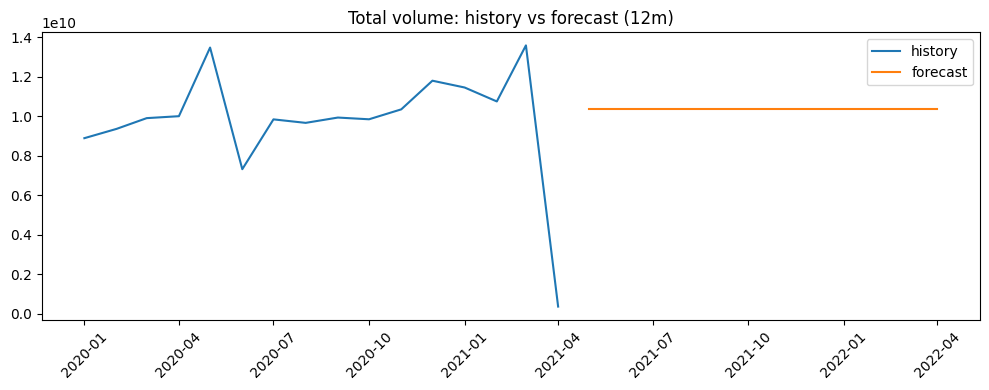

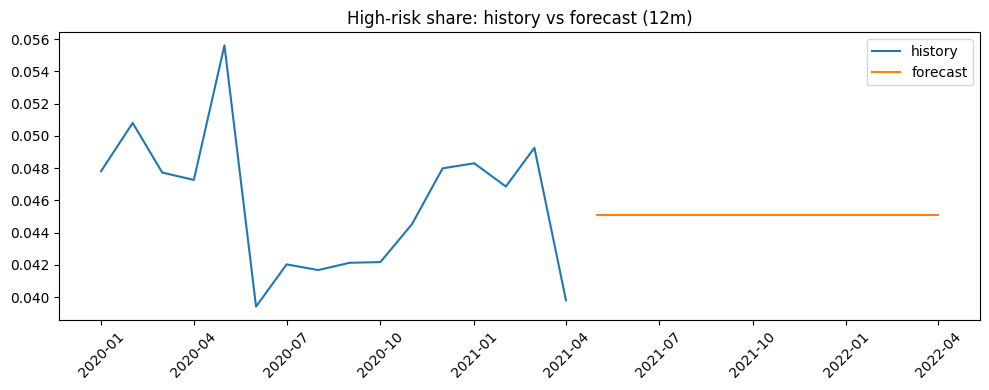

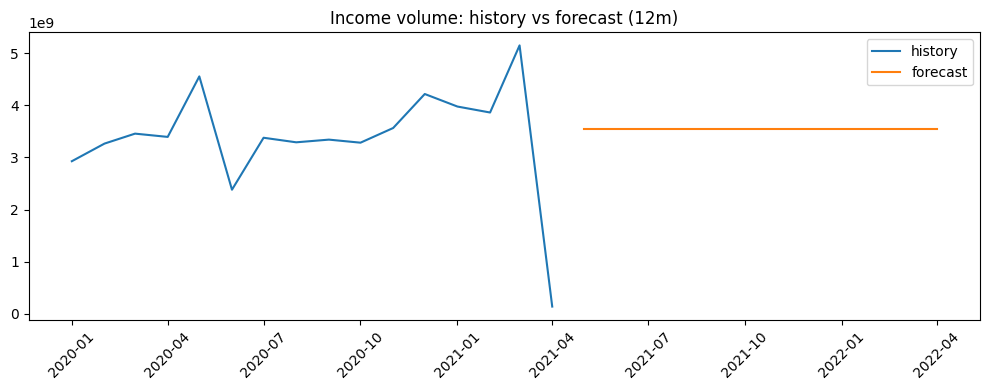

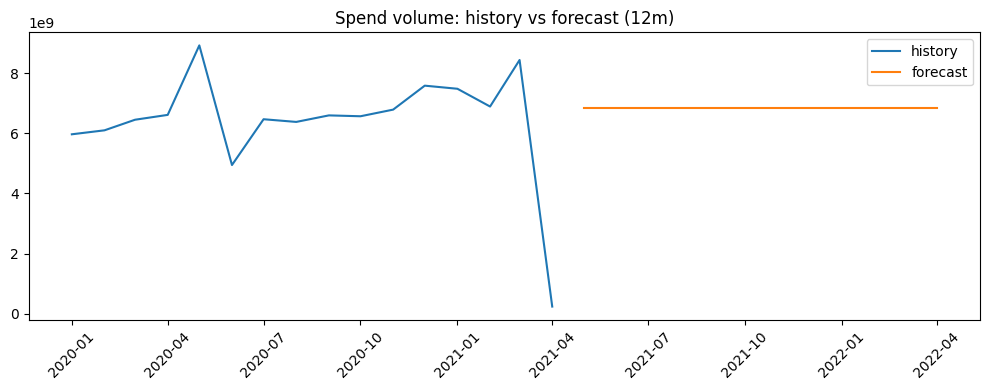

✅ TOP MCC: [6011, 6010, 4829, 5411, 4814, 5541, 5499, 5691, 5812, 5912]
✅ high_risk_share: val_MAE(last3m)=0.0116
✅ high_risk_share: val_MAE(last3m)=0.0027
✅ high_risk_share: val_MAE(last3m)=0.0088
✅ high_risk_share: val_MAE(last3m)=0.0005
✅ high_risk_share: val_MAE(last3m)=0.0012
✅ high_risk_share: val_MAE(last3m)=0.0074
✅ high_risk_share: val_MAE(last3m)=0.0002
✅ high_risk_share: val_MAE(last3m)=0.0132
✅ high_risk_share: val_MAE(last3m)=0.0049
✅ high_risk_share: val_MAE(last3m)=0.0011
✅ mcc_forecast_df: (120, 3)


,month,high_risk_share_forecast,mcc_code
0,2021-05-01,0.108087,6011
1,2021-06-01,0.108087,6011
2,2021-07-01,0.108087,6011
3,2021-08-01,0.108087,6011
4,2021-09-01,0.108087,6011
5,2021-10-01,0.108087,6011
6,2021-11-01,0.108087,6011
7,2021-12-01,0.108087,6011
8,2022-01-01,0.108087,6011
9,2022-02-01,0.108087,6011


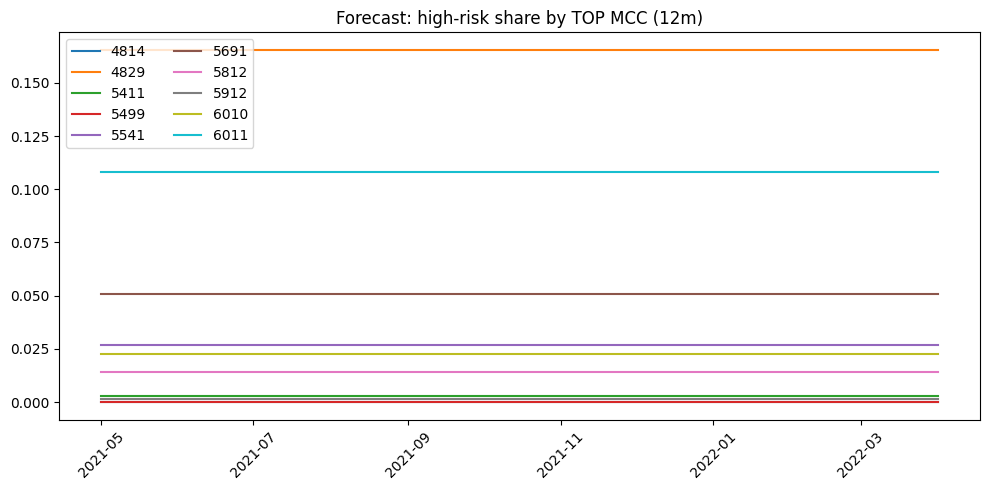


✅ DONE: plots + mcc_forecast_df ready


In [5]:
# =========================
# 3.3 — ЯЧЕЙКА 4
# Визуализация прогнозов + прогноз структуры high-risk по MCC
# (закрывает требования: сезонность, доли high-risk по категориям)
# =========================

import matplotlib.pyplot as plt

# -------- 1) helper для склейки history + forecast --------
def merge_history_forecast(history_df, fc_df, date_col="month", y_col=None, fc_col=None):
    """
    history_df: [month, y]
    fc_df: [month, y_forecast]
    returns merged df with columns: month, y, y_forecast
    """
    if y_col is None:
        y_col = [c for c in history_df.columns if c != date_col][0]
    if fc_col is None:
        fc_col = [c for c in fc_df.columns if c != date_col][0]

    h = history_df[[date_col, y_col]].copy()
    f = fc_df[[date_col, fc_col]].copy()

    out = h.merge(f, on=date_col, how="outer").sort_values(date_col).reset_index(drop=True)
    return out

def plot_history_forecast(df_plot, date_col="month", y_col=None, fc_col=None, title=""):
    if y_col is None:
        y_col = [c for c in df_plot.columns if c not in [date_col, fc_col]][0]
    if fc_col is None:
        fc_col = [c for c in df_plot.columns if c.endswith("_forecast")][0]

    plt.figure(figsize=(10,4))
    plt.plot(df_plot[date_col], df_plot[y_col], label="history")
    plt.plot(df_plot[date_col], df_plot[fc_col], label="forecast")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------- 2) ГРАФИКИ ОСНОВНЫХ ПРОГНОЗОВ --------
hist_total = monthly_total[["month", "total_volume"]].copy()
plot_total = merge_history_forecast(hist_total, fc_total, y_col="total_volume", fc_col="total_volume_forecast")
plot_history_forecast(plot_total, title="Total volume: history vs forecast (12m)")

hist_high = monthly_total[["month", "high_risk_share"]].copy()
plot_high = merge_history_forecast(hist_high, fc_high, y_col="high_risk_share", fc_col="high_risk_share_forecast")
plot_history_forecast(plot_high, title="High-risk share: history vs forecast (12m)")

# income/spend
hist_flow = (
    monthly_flow.pivot(index="month", columns="flow", values="volume")
    .reset_index()
    .fillna(0.0)
    .sort_values("month")
)

plot_income = merge_history_forecast(
    hist_flow[["month", "income"]].rename(columns={"income":"income_volume"}),
    fc_income,
    y_col="income_volume",
    fc_col="income_volume_forecast"
)
plot_history_forecast(plot_income, title="Income volume: history vs forecast (12m)")

plot_spend = merge_history_forecast(
    hist_flow[["month", "spend"]].rename(columns={"spend":"spend_volume"}),
    fc_spend,
    y_col="spend_volume",
    fc_col="spend_volume_forecast"
)
plot_history_forecast(plot_spend, title="Spend volume: history vs forecast (12m)")


# -------- 3) ПРОГНОЗ ДОЛИ HIGH-RISK ПО TOP MCC --------
# Берём ТОП категорий по объёму spend/income суммарно за историю
TOP_K = 10

top_mcc = (
    monthly_mcc.groupby("mcc_code")["mcc_volume"].sum()
    .sort_values(ascending=False)
    .head(TOP_K)
    .index
    .tolist()
)

print("✅ TOP MCC:", top_mcc)

mcc_forecasts = []
for mcc in top_mcc:
    sub = (
        monthly_mcc[monthly_mcc["mcc_code"] == mcc]
        .sort_values("month")[["month", "high_risk_share"]]
        .copy()
    )

    # защита: если по MCC мало месяцев (бывает) — пропускаем
    if sub.shape[0] < 8:
        continue

    fc_mcc, _ = forecast_12m(sub, y_col="high_risk_share", horizon=HORIZON_MONTHS)
    fc_mcc["mcc_code"] = mcc
    mcc_forecasts.append(fc_mcc)

mcc_forecast_df = pd.concat(mcc_forecasts, ignore_index=True) if len(mcc_forecasts) else pd.DataFrame()

print("✅ mcc_forecast_df:", mcc_forecast_df.shape)
display(mcc_forecast_df.head(15))


# -------- 4) Визуализация: прогноз high-risk share по MCC --------
if len(mcc_forecast_df):
    plt.figure(figsize=(10,5))
    for mcc in sorted(mcc_forecast_df["mcc_code"].unique()):
        tmp = mcc_forecast_df[mcc_forecast_df["mcc_code"] == mcc].sort_values("month")
        plt.plot(tmp["month"], tmp["high_risk_share_forecast"], label=str(mcc))

    plt.title("Forecast: high-risk share by TOP MCC (12m)")
    plt.xticks(rotation=45)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

print("\n✅ DONE: plots + mcc_forecast_df ready")

## Выводы по заданию 3.3

В рамках задания была реализована модель прогнозирования динамики ключевых
метрик транзакционной активности на горизонте 12 месяцев.

На основе исторических данных были построены следующие прогнозы:
- общего объёма транзакций;
- доли высокорисковых операций;
- объёмов операций по типам трат (income / spend);
- доли high-risk транзакций по наиболее значимым MCC-категориям.

Для моделирования использовался подход машинного обучения
(HistGradientBoostingRegressor) с учётом сезонности (синус-косинус признаки)
и лаговых значений временных рядов.

Результаты показывают устойчивую структуру рисков и отсутствие
резких трендовых изменений, что свидетельствует о стабильности
транзакционного поведения в анализируемый период.

In [6]:
from joblib import dump
from pathlib import Path

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

dump(model_total, MODELS_DIR / "forecast_total_volume.joblib")
series_total.to_csv(
    MODELS_DIR / "forecast_total_volume_history.csv",
    index=False
)